# Abstractive versus Extractive

In [1]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring
from functools import partial
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  

In [12]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [13]:
## encoding
token_candidates = ["Paris", "France", "Poland", "Warsaw"]
prompts = [("Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:",
            'Q: What is the capital of Poland? Options: "A" Berlin, "B" Warsaw, "C" Paris A:'),
           ("Q: What is the relationship between Harry Potter and Ronald Weasley? A: Friends Q: What is the relationship between Joe Biden and Donald Trump? A:",
            'Q: What is the relationship between Joe Biden and Donald Trump? Options: "A" Friends "B" Enemies A:')]

example = 0
i = 0
logits, activs, tokens = decoding.encode(prompts[example][i], model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(logits[:,-1,:], k=10).indices.tolist()[0])
print(pred, (len(tokens[0])))

['ĠWarsaw', 'ĠPoland', 'ĠW', 'ĠParis', 'ĠK', 'ĠPrague', 'ĠPo', 'ĠP', 'ĠB', 'ĠL'] 23


In [14]:
def token_select(layer_token_vec, tok_type="last"):
    if tok_type == "last":
        layer_token_vec = layer_token_vec[...,-1].squeeze().detach()
    if tok_type == "mean":
        layer_token_vec = layer_token_vec.mean(-1).squeeze().detach()
    return layer_token_vec

In [15]:
def get_norms(model, activs, mods=["attn_out","resid_mid"], tok_type="last"):    
    
    mod_layer_norms = {}
    for mod in mods:
        layer_norms = []
        for layer in range(0,model.cfg.n_layers):
            mod_name = transformer_lens.utils.get_act_name(mod, layer)
            mod_activs = activs[mod_name]
            
            mod_activs_norm = torch.linalg.norm(mod_activs,dim=-1).squeeze()
            mod_activs_norm = token_select(mod_activs_norm, tok_type=tok_type)
            
            layer_norms.append(mod_activs_norm)
        mod_layer_norms[mod] = torch.stack(layer_norms).squeeze().numpy()
    return mod_layer_norms
    
    
#"resid_mid", "resid_post"
mods=["attn_out","mlp_out"]
mod_layer_norms = get_norms(model, activs, mods=mods, tok_type="last")

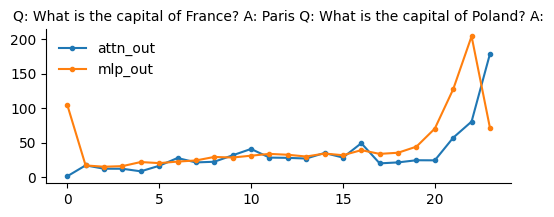

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


fig, ax = plt.subplots(1, 1, figsize=(6, 2), gridspec_kw={'hspace': 0.4})

mods = list(mod_layer_norms.keys())
layers = np.array(list(range(0,model.cfg.n_layers)))

for mod in mods:
    lines = ax.plot(layers, mod_layer_norms[mod], marker=".", label=mod)

ax.set_title(prompts[0][i], fontsize=10, color="black", loc='center')
ax.legend(frameon=False)

In [9]:
def get_distance(model, activs, mods_pairs=[("attn_out","resid_mid"), ("mlp_out","resid_post")], tok_type="last"):    
    
    mod_layer_norms = {}
    #pdist = torch.nn.PairwiseDistance(p=2)
    cos_sim = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    
    for mods_pair in mods_pairs:
        layer_norms = []
        for layer in range(0,model.cfg.n_layers):
            mod_name_0 = transformer_lens.utils.get_act_name(mods_pair[0], layer)
            mod_activs_0 = activs[mod_name_0]
            mod_name_1 = transformer_lens.utils.get_act_name(mods_pair[1], layer)
            mod_activs_1 = activs[mod_name_1]
            
            #mod_activs_0 = torch.nn.functional.normalize(mod_activs_0, p=1.0, dim=-1)
            #mod_activs_1 = torch.nn.functional.normalize(mod_activs_1, p=1.0, dim=-1)
            
            activs_dist = 1-cos_sim(mod_activs_0, mod_activs_1)
            activs_dist = token_select(activs_dist, tok_type=tok_type)

            layer_norms.append(activs_dist)
        mod_layer_norms[f"{mods_pair[0]}/{mods_pair[1]}"] = torch.stack(layer_norms).squeeze().numpy()
    return mod_layer_norms
    
    
mods_pairs=[("attn_out","resid_mid"), ("mlp_out","resid_post")]
mod_layer_dist = get_distance(model, activs, mods_pairs=mods_pairs, tok_type="last")
mod_layer_dist

{'attn_out/resid_mid': array([0.5971809 , 0.71104646, 0.49440265, 0.8697512 , 0.72579384,
        0.55095387, 0.5324377 , 0.5935483 , 0.6580627 , 0.6450092 ,
        0.5813967 , 0.75355697, 0.68889165, 0.6970525 , 0.6541486 ,
        0.74548817, 0.5083076 , 0.68524784, 0.47057873, 0.45361596,
        0.41178262, 0.20640999, 0.25054806, 0.69029254], dtype=float32),
 'mlp_out/resid_post': array([3.9088726e-04, 5.3808880e-01, 1.3880994e+00, 9.3885040e-01,
        7.0141101e-01, 6.9471908e-01, 6.8792069e-01, 8.6790329e-01,
        6.3482702e-01, 8.4251928e-01, 9.5088494e-01, 9.3155736e-01,
        1.0296160e+00, 9.4029313e-01, 7.5773150e-01, 9.2580491e-01,
        6.7303443e-01, 7.7282906e-01, 8.1319666e-01, 6.2030989e-01,
        3.6248422e-01, 1.9827843e-01, 9.4884694e-02, 6.4851403e-01],
       dtype=float32)}

{'attn_out/resid_mid': 14.175505, 'mlp_out/resid_post': 17.014149}

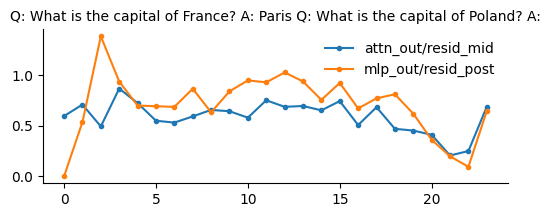

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


fig, ax = plt.subplots(1, 1, figsize=(6, 2), gridspec_kw={'hspace': 0.4})

mods = list(mod_layer_dist.keys())
layers = np.array(list(range(0,model.cfg.n_layers)))

for mod in mods:
    lines = ax.plot(layers, mod_layer_dist[mod], marker=".", label=mod)

ax.set_title(prompts[example][i], fontsize=10, color="black", loc='center')
ax.legend(frameon=False)


{k: v.sum() for k,v in mod_layer_dist.items()}

In [310]:
{'attn_out/resid_mid': 5.8119445, 'mlp_out/resid_post': 6.402007}

{'attn_out/resid_mid': 5.8119445, 'mlp_out/resid_post': 6.402007}